<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.56 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 12:31:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 133 kB 30.7 MB/s 
     |████████████████████████████████| 138 kB 30.9 MB/s 
     |████████████████████████████████| 170 kB 30.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: jipkt1le
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/jipkt1le


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: vgfgz14c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 24s 223ms/step - loss: 0.1999 - mean_squared_error: 0.1999 - mean_absolute_error: 0.3989 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0693
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1471 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1110
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1072 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1050
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0833 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0607
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0109 - mean_squared_error: 0.0109

epoch,49
loss,0.00205
mean_squared_error,0.00205
mean_absolute_error,0.03624
val_loss,0.00335
val_mean_squared_error,0.00335
val_mean_absolute_error,0.04495
_runtime,40
_timestamp,1626784348
_step,49
best_val_loss,0.00249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▇▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▇▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▇▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l9m0zsxh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 100ms/step - loss: 0.9348 - mean_squared_error: 0.9348 - mean_absolute_error: 0.7264 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1481
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1326 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0903
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1177 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0623
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1281 - val_loss: 0.0787 - val_mean_squared_error: 0.0787 - val_mean_absolute_error: 0.2701
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0314 - mean_squared_erro

epoch,16
loss,0.01
mean_squared_error,0.01
mean_absolute_error,0.08278
val_loss,0.00367
val_mean_squared_error,0.00367
val_mean_absolute_error,0.04875
_runtime,16
_timestamp,1626784390
_step,16
best_val_loss,0.0028


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁
val_loss,▃▂▁█▂▃▁▁▂▂▅▃▅▁▂▂▁
val_mean_squared_error,▃▂▁█▂▃▁▁▂▂▅▃▅▁▂▂▁
val_mean_absolute_error,▄▂▂█▃▄▁▁▃▂▆▃▆▁▃▂▁
_runtime,▁▁▁▃▃▃▃▃▆▆▆▆▆████
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆▆████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: gp8123qa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 202ms/step - loss: 0.1876 - mean_squared_error: 0.1876 - mean_absolute_error: 0.3845 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0597
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0738 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0605
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0660 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0637
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0607 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043 

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03698
val_loss,0.00319
val_mean_squared_error,0.00319
val_mean_absolute_error,0.04396
_runtime,21
_timestamp,1626784423
_step,49
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▅▅▃▃▂█▃▃▂▂▂▂▂▄▂▂▂▃▂▂▂▄▂▂▁▂▂▂▁▂▁▂▃▁▁▁▂▁▂
val_mean_squared_error,▄▅▅▃▃▂█▃▃▂▂▂▂▂▄▂▂▂▃▂▂▂▄▂▂▁▂▂▂▁▂▁▂▃▁▁▁▂▁▂
val_mean_absolute_error,▄▄▅▃▃▂█▃▄▂▂▃▂▂▄▂▂▂▄▂▃▃▅▂▂▁▂▂▂▁▂▁▂▃▁▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8vfpkifx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 7s 213ms/step - loss: 0.2088 - mean_squared_error: 0.2088 - mean_absolute_error: 0.4036 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0671
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1332 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1075
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.1003 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0923
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0747 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0565
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0069 - mean_squared_error: 0.

epoch,99
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02822
val_loss,0.00196
val_mean_squared_error,0.00196
val_mean_absolute_error,0.03499
_runtime,27
_timestamp,1626784463
_step,99
best_val_loss,0.00175


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cxvye8ck with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 107ms/step - loss: 0.1258 - mean_squared_error: 0.1258 - mean_absolute_error: 0.2726 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.2014
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1139 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1842
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0671 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1644
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0640 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0816
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0065 - mean_squared_erro

epoch,35
loss,0.00193
mean_squared_error,0.00193
mean_absolute_error,0.03411
val_loss,0.00194
val_mean_squared_error,0.00194
val_mean_absolute_error,0.03419
_runtime,24
_timestamp,1626784505
_step,35
best_val_loss,0.00189


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▃▂▂▁▁▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁
val_loss,█▇▆▂▂▄▁▁▁▁▁▁▁▁▁▂▁▁▃▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▇▆▂▂▄▁▁▁▁▁▁▁▁▁▂▁▁▃▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▆▃▃▅▂▂▂▁▁▂▂▁▂▂▁▂▄▁▂▁▁▃▃▁▂▁▁▁▂▁▂▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: orob59ix with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 20s 282ms/step - loss: 0.1900 - mean_squared_error: 0.1900 - mean_absolute_error: 0.3864 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1176
Epoch 2/50
32/32 [==============================] - 7s 229ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1053 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0911
Epoch 3/50
32/32 [==============================] - 7s 222ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0704 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0569
Epoch 4/50
32/32 [==============================] - 7s 233ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 5/50
32/32 [==============================] - 8s 245ms/step - loss: 0.0036 - mean_squared

epoch,33
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.03231
val_loss,0.0037
val_mean_squared_error,0.0037
val_mean_absolute_error,0.04817
_runtime,270
_timestamp,1626784787
_step,33
best_val_loss,0.0026


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▂▂▂▂▃▃▂▁▂▂▁▁▁▁▂▂▁▂▂▂▁▁▂▁▂▂▂▂▁▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xix69clr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 107ms/step - loss: 1.3248 - mean_squared_error: 1.3248 - mean_absolute_error: 0.8676 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1634
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1382 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.2169
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1494 - val_loss: 0.3089 - val_mean_squared_error: 0.3089 - val_mean_absolute_error: 0.5436
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.1662 - mean_squared_error: 0.1662 - mean_absolute_error: 0.3397 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1199
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0241 - mean_squared_erro

epoch,23
loss,0.00661
mean_squared_error,0.00661
mean_absolute_error,0.06728
val_loss,0.00442
val_mean_squared_error,0.00442
val_mean_absolute_error,0.0553
_runtime,19
_timestamp,1626784818
_step,23
best_val_loss,0.00276


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▁▁▁▁▃▁▂▁▃▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▂▂█▁▁▁▁▃▁▂▁▃▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▃▃█▂▂▂▂▄▂▃▁▄▂▁▁▁▂▁▂▂▃▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: uv5k5haq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 9s 441ms/step - loss: 0.2298 - mean_squared_error: 0.2298 - mean_absolute_error: 0.4386 - val_loss: 0.0827 - val_mean_squared_error: 0.0827 - val_mean_absolute_error: 0.2619
Epoch 2/200
8/8 [==============================] - 2s 241ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1571 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0953
Epoch 3/200
8/8 [==============================] - 2s 231ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1219 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1720
Epoch 4/200
8/8 [==============================] - 2s 231ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1116 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0684
Epoch 5/200
8/8 [==============================] - 2s 233ms/step - loss: 0.0121 - mean_squared_error

epoch,25
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.03841
val_loss,0.00344
val_mean_squared_error,0.00344
val_mean_absolute_error,0.04541
_runtime,63
_timestamp,1626784896
_step,25
best_val_loss,0.00282


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▅▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: e48fc9gr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 7s 205ms/step - loss: 0.2047 - mean_squared_error: 0.2047 - mean_absolute_error: 0.4012 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1149
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1618 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1478
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1109 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0754
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0797 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0578
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066 

epoch,49
loss,0.00178
mean_squared_error,0.00178
mean_absolute_error,0.03297
val_loss,0.0022
val_mean_squared_error,0.0022
val_mean_absolute_error,0.0372
_runtime,22
_timestamp,1626784958
_step,49
best_val_loss,0.0022


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: szf4j8xq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 16s 280ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - mean_absolute_error: 0.3042 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0861
Epoch 2/200
32/32 [==============================] - 7s 230ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0789 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0927
Epoch 3/200
32/32 [==============================] - 7s 228ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0656 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0735
Epoch 4/200
32/32 [==============================] - 7s 227ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0599 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0546
Epoch 5/200
32/32 [==============================] - 7s 229ms/step - loss: 0.0053 - mean_sq

epoch,31
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.0354
val_loss,0.00524
val_mean_squared_error,0.00524
val_mean_absolute_error,0.05519
_runtime,257
_timestamp,1626785228
_step,31
best_val_loss,0.00323


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▃▂▄▂▄▄█▅▂▅▂▃▁▅▂▁▂▂▃▁▁▂▄▄▃▂▁▂▃▂
val_mean_squared_error,▅▅▃▂▄▂▄▄█▅▂▅▂▃▁▅▂▁▂▂▃▁▁▂▄▄▃▂▁▂▃▂
val_mean_absolute_error,▅▆▄▂▄▂▄▅█▅▃▅▃▃▁▆▃▁▂▂▃▁▁▃▄▄▃▂▁▂▄▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: id4lxzsw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 291ms/step - loss: 0.1840 - mean_squared_error: 0.1840 - mean_absolute_error: 0.3831 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0631
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0797 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0644
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0720 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0606
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0661 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0775
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061 

epoch,49
loss,0.00305
mean_squared_error,0.00305
mean_absolute_error,0.04418
val_loss,0.00411
val_mean_squared_error,0.00411
val_mean_absolute_error,0.05079
_runtime,22
_timestamp,1626785278
_step,49
best_val_loss,0.00258


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▄▆▂▃▂▂▅▂▂▅▂▃▂▂▂▁▂█▂▄▂▂▁▁▁▂▁▂▂▁▁▁▂▄▁▁▁▂
val_mean_squared_error,▄▄▄▆▂▃▂▂▅▂▂▅▂▃▂▂▂▁▂█▂▄▂▂▁▁▁▂▁▂▂▁▁▁▂▄▁▁▁▂
val_mean_absolute_error,▄▄▄▆▂▄▂▃▅▂▂▅▂▃▂▂▂▁▂█▂▄▂▂▁▁▁▂▁▂▂▁▁▁▂▄▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hodhppdx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 54ms/step - loss: 0.7479 - mean_squared_error: 0.7479 - mean_absolute_error: 0.4592 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1956
Epoch 2/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1410 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1210
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1382 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1784
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1551 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0855
Epoch 5/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0186 - mean_squared_

epoch,26
loss,0.00432
mean_squared_error,0.00432
mean_absolute_error,0.05245
val_loss,0.00482
val_mean_squared_error,0.00482
val_mean_absolute_error,0.05437
_runtime,23
_timestamp,1626785324
_step,26
best_val_loss,0.00243


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▂▄▂▂█▂▂▃▁▄▃▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▂▄▂▂█▂▂▃▁▄▃▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▄▅▂▂█▃▃▄▁▅▄▁▂▂▂▁▃▂▂▁▂▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 7u775hkj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 10s 455ms/step - loss: 0.2159 - mean_squared_error: 0.2159 - mean_absolute_error: 0.3912 - val_loss: 0.1934 - val_mean_squared_error: 0.1934 - val_mean_absolute_error: 0.4158
Epoch 2/100
8/8 [==============================] - 2s 224ms/step - loss: 0.0887 - mean_squared_error: 0.0887 - mean_absolute_error: 0.2568 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1391
Epoch 3/100
8/8 [==============================] - 2s 235ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1498 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1389
Epoch 4/100
8/8 [==============================] - 2s 234ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1495 - val_loss: 0.0574 - val_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.1968
Epoch 5/100
8/8 [==============================] - 2s 232ms/step - loss: 0.0344 - mean_squared_erro

epoch,58
loss,0.00198
mean_squared_error,0.00198
mean_absolute_error,0.035
val_loss,0.00328
val_mean_squared_error,0.00328
val_mean_absolute_error,0.0437
_runtime,125
_timestamp,1626785470
_step,58
best_val_loss,0.00297


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: alhejrmm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 11s 493ms/step - loss: 0.2586 - mean_squared_error: 0.2586 - mean_absolute_error: 0.4726 - val_loss: 0.3013 - val_mean_squared_error: 0.3013 - val_mean_absolute_error: 0.5306
Epoch 2/200
8/8 [==============================] - 2s 247ms/step - loss: 0.1262 - mean_squared_error: 0.1262 - mean_absolute_error: 0.3080 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0882
Epoch 3/200
8/8 [==============================] - 2s 254ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1028 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0943
Epoch 4/200
8/8 [==============================] - 2s 255ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0925 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0943
Epoch 5/200
8/8 [==============================] - 2s 246ms/step - loss: 0.0104 - mean_squared_erro

epoch,26
loss,0.00335
mean_squared_error,0.00335
mean_absolute_error,0.04496
val_loss,0.01081
val_mean_squared_error,0.01081
val_mean_absolute_error,0.08695
_runtime,67
_timestamp,1626785575
_step,26
best_val_loss,0.00418


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▂▂▁▂
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 4thorofq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 107ms/step - loss: 1.4502 - mean_squared_error: 1.4502 - mean_absolute_error: 0.6683 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1400
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1505 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0634
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1424 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1263
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1249 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0769
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0277 - mean_squared

epoch,29
loss,0.00479
mean_squared_error,0.00479
mean_absolute_error,0.05806
val_loss,0.00438
val_mean_squared_error,0.00438
val_mean_absolute_error,0.05209
_runtime,20
_timestamp,1626785634
_step,29
best_val_loss,0.00204


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▃▂▂▃▂▃▃▁▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁
val_loss,▆▂▆▃▂▅▃▁▂▂▃▅▅▁▂█▇█▅▁▂▂▁▂▃▁▂▁▁▁
val_mean_squared_error,▆▂▆▃▂▅▃▁▂▂▃▅▅▁▂█▇█▅▁▂▂▁▂▃▁▂▁▁▁
val_mean_absolute_error,▆▂▆▃▃▆▃▂▂▃▄▆▇▂▄███▅▁▂▂▂▂▃▁▃▁▁▂
_runtime,▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
_timestamp,▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: cis69d85 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 10s 447ms/step - loss: 0.2432 - mean_squared_error: 0.2432 - mean_absolute_error: 0.4571 - val_loss: 0.2403 - val_mean_squared_error: 0.2403 - val_mean_absolute_error: 0.4724
Epoch 2/50
8/8 [==============================] - 2s 250ms/step - loss: 0.1010 - mean_squared_error: 0.1010 - mean_absolute_error: 0.2790 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0752
Epoch 3/50
8/8 [==============================] - 2s 224ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1406 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0813
Epoch 4/50
8/8 [==============================] - 2s 241ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.1010 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1788
Epoch 5/50
8/8 [==============================] - 2s 243ms/step - loss: 0.0190 - mean_squared_error: 0.

epoch,19
loss,0.00381
mean_squared_error,0.00381
mean_absolute_error,0.04776
val_loss,0.01191
val_mean_squared_error,0.01191
val_mean_absolute_error,0.09268
_runtime,53
_timestamp,1626785709
_step,19
best_val_loss,0.00498


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▃▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: yw1j57u0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 207ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - mean_absolute_error: 0.3120 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0621
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1426 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1279
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.1029 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1587
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.1024 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1526
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0104 - mean_squared_error: 0.

epoch,15
loss,0.00494
mean_squared_error,0.00494
mean_absolute_error,0.05782
val_loss,0.01362
val_mean_squared_error,0.01362
val_mean_absolute_error,0.10465
_runtime,16
_timestamp,1626785738
_step,15
best_val_loss,0.00456


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▁▂▂
val_loss,▁▆█▇▄▁▄▇▅▄▂▄▂▄▃▃
val_mean_squared_error,▁▆█▇▄▁▄▇▅▄▂▄▂▄▃▃
val_mean_absolute_error,▂▆██▅▁▅▇▆▅▂▅▂▅▃▄
_runtime,▁▁▁▁▁▅▅▅▅▅▅█████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 5saj8hh1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 13s 352ms/step - loss: 0.2204 - mean_squared_error: 0.2204 - mean_absolute_error: 0.4287 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1160
Epoch 2/100
16/16 [==============================] - 4s 239ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1286 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1810
Epoch 3/100
16/16 [==============================] - 4s 236ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1204 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0739
Epoch 4/100
16/16 [==============================] - 4s 223ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0848 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0647
Epoch 5/100
16/16 [==============================] - 4s 235ms/step - loss: 0.0073 - mean_sq

epoch,25
loss,0.00212
mean_squared_error,0.00212
mean_absolute_error,0.03626
val_loss,0.00386
val_mean_squared_error,0.00386
val_mean_absolute_error,0.04867
_runtime,112
_timestamp,1626785866
_step,25
best_val_loss,0.00318


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 5cnfgbeo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 224ms/step - loss: 0.1846 - mean_squared_error: 0.1846 - mean_absolute_error: 0.3603 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0760
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0783 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0582
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0723 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0746
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0738 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0646
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0053 - mean_squared_error: 0.

epoch,70
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03359
val_loss,0.00214
val_mean_squared_error,0.00214
val_mean_absolute_error,0.03624
_runtime,28
_timestamp,1626785908
_step,70
best_val_loss,0.00194


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▅█▄▂▅▂▂▃▂▂▂▂▂▂▁▅▁▂▂▂▂▁▁▂▂▁▁▃▁▁▁▃▁▂▁▁▂▁
val_mean_squared_error,▇▄▅█▄▂▅▂▂▃▂▂▂▂▂▂▁▅▁▂▂▂▂▁▁▂▂▁▁▃▁▁▁▃▁▂▁▁▂▁
val_mean_absolute_error,▆▄▅█▄▂▅▃▂▃▂▃▂▂▃▂▂▆▂▂▂▂▃▂▁▂▂▁▁▄▁▁▁▄▁▂▂▁▂▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kx1lx58u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 111ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - mean_absolute_error: 0.3041 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0614
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0837 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0652
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0768 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0498
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0554 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0743
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0051 - mean_squared_erro

epoch,14
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03686
val_loss,0.00257
val_mean_squared_error,0.00257
val_mean_absolute_error,0.04062
_runtime,19
_timestamp,1626785943
_step,14
best_val_loss,0.00232


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▃▁▁▁▂▂▁▁
val_loss,▄▄▂▅▁▃█▃▂▃▁▂▁▁▁
val_mean_squared_error,▄▄▂▅▁▃█▃▂▃▁▂▁▁▁
val_mean_absolute_error,▄▄▂▆▁▃█▄▂▄▂▃▂▁▁
_runtime,▁▁▁▃▃▃▅▅▅▅▆▆▆██
_timestamp,▁▁▁▃▃▃▅▅▅▅▆▆▆██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 1n2gjqbp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 9s 451ms/step - loss: 0.2388 - mean_squared_error: 0.2388 - mean_absolute_error: 0.4510 - val_loss: 0.0863 - val_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.2689
Epoch 2/200
8/8 [==============================] - 2s 234ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1599 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0940
Epoch 3/200
8/8 [==============================] - 2s 234ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1174 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1739
Epoch 4/200
8/8 [==============================] - 2s 251ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1109 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0669
Epoch 5/200
8/8 [==============================] - 2s 239ms/step - loss: 0.0107 - mean_squared_error

epoch,57
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03324
val_loss,0.00256
val_mean_squared_error,0.00256
val_mean_absolute_error,0.03936
_runtime,125
_timestamp,1626786083
_step,57
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nphnt6bg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 13s 339ms/step - loss: 0.1772 - mean_squared_error: 0.1772 - mean_absolute_error: 0.3691 - val_loss: 0.0476 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1861
Epoch 2/50
16/16 [==============================] - 4s 237ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1339 - val_loss: 0.1142 - val_mean_squared_error: 0.1142 - val_mean_absolute_error: 0.3161
Epoch 3/50
16/16 [==============================] - 4s 242ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1220 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0810
Epoch 4/50
16/16 [==============================] - 4s 236ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1158 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0987
Epoch 5/50
16/16 [==============================] - 4s 241ms/step - loss: 0.0136 - mean_squared

epoch,18
loss,0.00514
mean_squared_error,0.00514
mean_absolute_error,0.05809
val_loss,0.01338
val_mean_squared_error,0.01338
val_mean_absolute_error,0.0954
_runtime,89
_timestamp,1626786211
_step,18
best_val_loss,0.00582


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,▄█▁▂▂▁▂▁▁▁▃▁▁▁▃▁▁▁▁
val_mean_squared_error,▄█▁▂▂▁▂▁▁▁▃▁▁▁▃▁▁▁▁
val_mean_absolute_error,▄█▂▂▂▁▃▂▁▁▄▁▁▁▄▁▂▁▂
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: vwb58uov with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 7s 209ms/step - loss: 0.2700 - mean_squared_error: 0.2700 - mean_absolute_error: 0.4127 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0870
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1409 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0814
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1093 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1000
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0658 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0531
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037 

epoch,47
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.02916
val_loss,0.00196
val_mean_squared_error,0.00196
val_mean_absolute_error,0.03508
_runtime,22
_timestamp,1626786250
_step,47
best_val_loss,0.00168


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆█▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▇▆█▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▇▆█▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5lk1tv13 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 58ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - mean_absolute_error: 0.2191 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0517
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0459
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0421 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0436
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0381 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0432
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0025 - mean_squared_

epoch,43
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02656
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03692
_runtime,34
_timestamp,1626786298
_step,43
best_val_loss,0.00163


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▆▃▃▃▃▃▂▂▄▂▂▂▃▁▂▃▂▁▃▁▂▂▁▁▂▁▁▁▁▁▁▂▂▃▂▂
val_mean_squared_error,█▅▅▅▆▃▃▃▃▃▂▂▄▂▂▂▃▁▂▃▂▁▃▁▂▂▁▁▂▁▁▁▁▁▁▂▂▃▂▂
val_mean_absolute_error,█▆▅▅▆▄▄▃▄▄▂▃▄▂▂▃▄▂▃▄▂▁▄▁▂▂▂▁▃▁▁▁▂▁▁▂▂▃▃▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wier0zy7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 13s 363ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - mean_absolute_error: 0.3666 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1041
Epoch 2/200
16/16 [==============================] - 4s 251ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0823 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0551
Epoch 3/200
16/16 [==============================] - 4s 229ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0621 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 4/200
16/16 [==============================] - 4s 231ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0647
Epoch 5/200
16/16 [==============================] - 4s 231ms/step - loss: 0.0043 - mean_sq

epoch,41
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03607
val_loss,0.0041
val_mean_squared_error,0.0041
val_mean_absolute_error,0.04999
_runtime,179
_timestamp,1626786521
_step,41
best_val_loss,0.00293


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▃▄▃▂▂▃▁▂▅▂▁▁▃▁▂▁▁▁▁▂▁▇▂▂▁▁▂▁▂▁▅▃▂▂▃▁▂
val_mean_squared_error,█▂▂▃▄▃▂▂▃▁▂▅▂▁▁▃▁▂▁▁▁▁▂▁▇▂▂▁▁▂▁▂▁▅▃▂▂▃▁▂
val_mean_absolute_error,█▂▂▃▄▄▂▂▃▂▂▅▂▁▁▃▁▂▁▁▂▁▃▂█▃▃▁▁▂▁▂▂▅▄▂▂▄▂▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: dw6i5gcf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 7s 109ms/step - loss: 1.1203 - mean_squared_error: 1.1203 - mean_absolute_error: 0.7716 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1368
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1258 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1073
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1651 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0601
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1492 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1691
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0218 - mean_squared_erro

epoch,20
loss,0.0096
mean_squared_error,0.0096
mean_absolute_error,0.08016
val_loss,0.04298
val_mean_squared_error,0.04298
val_mean_absolute_error,0.19475
_runtime,20
_timestamp,1626786593
_step,20
best_val_loss,0.00325


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
val_loss,▃▂▁▄▃▂▂▂▂▄▁█▁▃▁▁▁▂▁▁▄
val_mean_squared_error,▃▂▁▄▃▂▂▂▂▄▁█▁▃▁▁▁▂▁▁▄
val_mean_absolute_error,▄▃▁▅▄▃▃▃▃▅▁█▁▃▁▂▁▂▂▁▆
_runtime,▁▁▁▂▂▂▂▄▄▄▄▅▅▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▄▄▄▄▅▅▇▇▇▇████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: kyvarfvv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 12s 333ms/step - loss: 0.1112 - mean_squared_error: 0.1112 - mean_absolute_error: 0.2664 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0763
Epoch 2/50
16/16 [==============================] - 4s 235ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0856 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0731
Epoch 3/50
16/16 [==============================] - 4s 244ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0812 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0653
Epoch 4/50
16/16 [==============================] - 4s 233ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0722 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0545
Epoch 5/50
16/16 [==============================] - 4s 240ms/step - loss: 0.0075 - mean_squared

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,40
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03211
val_loss,0.00263
val_mean_squared_error,0.00263
val_mean_absolute_error,0.03928
_runtime,173
_timestamp,1626786781
_step,40
best_val_loss,0.00227


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▃▁▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▄▂▄▂▃▄▂█▄▂▆▃▂▂▂▁▃▂▁▂▁▂▂▃▂▂▁▅▁▂▂▂▂▂▁▁▁▁
val_mean_squared_error,▄▄▄▂▄▂▃▄▂█▄▂▆▃▂▂▂▁▃▂▁▂▁▂▂▃▂▂▁▅▁▂▂▂▂▂▁▁▁▁
val_mean_absolute_error,▅▅▄▃▄▂▄▅▂█▄▂▇▃▂▃▂▁▃▂▁▃▁▂▂▄▂▂▂▅▁▃▂▂▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: vpyl458p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 13s 351ms/step - loss: 0.1469 - mean_squared_error: 0.1469 - mean_absolute_error: 0.3151 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0921
Epoch 2/50
16/16 [==============================] - 4s 246ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0762 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0607
Epoch 3/50
16/16 [==============================] - 4s 255ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0665 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0682
Epoch 4/50
16/16 [==============================] - 4s 254ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0560 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0528
Epoch 5/50
16/16 [==============================] - 4s 232ms/step - loss: 0.0060 - mean_squared

epoch,39
loss,0.00286
mean_squared_error,0.00286
mean_absolute_error,0.04296
val_loss,0.01042
val_mean_squared_error,0.01042
val_mean_absolute_error,0.0858
_runtime,170
_timestamp,1626787001
_step,39
best_val_loss,0.00292


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▂▃▂█▃▂▂▄▅▇▅▃▁▂▁▃▂▆▅▁▂▁▁▁▄▆▃▁▁▁▁▁▅▃▂▁▆▃▄
val_mean_squared_error,▅▂▃▂█▃▂▂▄▅▇▅▃▁▂▁▃▂▆▅▁▂▁▁▁▄▆▃▁▁▁▁▁▅▃▂▁▆▃▄
val_mean_absolute_error,▅▃▃▂█▄▃▂▅▅▇▆▃▁▂▂▃▃▆▆▁▂▁▁▁▅▇▃▁▁▁▁▁▆▃▂▁▆▄▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lc5xz5tv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 10s 477ms/step - loss: 0.1689 - mean_squared_error: 0.1689 - mean_absolute_error: 0.3485 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - val_mean_absolute_error: 0.2700
Epoch 2/200
8/8 [==============================] - 2s 242ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1628 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0860
Epoch 3/200
8/8 [==============================] - 2s 237ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1059 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0640
Epoch 4/200
8/8 [==============================] - 2s 253ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0756 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0552
Epoch 5/200
8/8 [==============================] - 2s 231ms/step - loss: 0.0068 - mean_squared_erro

epoch,18
loss,0.00252
mean_squared_error,0.00252
mean_absolute_error,0.03953
val_loss,0.00447
val_mean_squared_error,0.00447
val_mean_absolute_error,0.05206
_runtime,51
_timestamp,1626787067
_step,18
best_val_loss,0.00299


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 9vtjawo0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 60ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - mean_absolute_error: 0.2171 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0583
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0594 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0532
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0487 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0477
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0448 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0450
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_

epoch,68
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.0273
val_loss,0.00172
val_mean_squared_error,0.00172
val_mean_absolute_error,0.03215
_runtime,47
_timestamp,1626787169
_step,68
best_val_loss,0.00162


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▃▃▆▂▂▄▃▂▂▂▂▁▁▂▁▂▁▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▂▁▁
val_mean_squared_error,█▆▄▄▄▃▃▆▂▂▄▃▂▂▂▂▁▁▂▁▂▁▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▅▄▅▄▃▇▃▃▄▃▂▂▂▃▂▂▃▂▂▁▂▃▂▁▁▃▂▂▁▃▂▁▁▁▂▃▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wiuyi00n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 229ms/step - loss: 0.1727 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3481 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0862
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1433 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0747
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1155 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0551
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0735 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0652
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0098 - mean_squared_error: 0.

epoch,40
loss,0.00286
mean_squared_error,0.00286
mean_absolute_error,0.04335
val_loss,0.00202
val_mean_squared_error,0.00202
val_mean_absolute_error,0.03534
_runtime,23
_timestamp,1626787211
_step,40
best_val_loss,0.00183


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▂▂▁▁▁▁▂▁
val_loss,▇▅▃▄▃▄▂▂█▂▂▃▂▄▂▂▂▂▄▂▂▂▁▁▁▁▂▄▁▁▁▁▅▂▁▁▂▃▂▁
val_mean_squared_error,▇▅▃▄▃▄▂▂█▂▂▃▂▄▂▂▂▂▄▂▂▂▁▁▁▁▂▄▁▁▁▁▅▂▁▁▂▃▂▁
val_mean_absolute_error,▇▅▃▄▃▄▂▂█▂▂▃▂▅▃▃▃▂▄▂▃▂▁▁▁▁▂▄▁▂▁▁▆▂▁▁▂▃▂▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: kzyrw9fw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 59ms/step - loss: 0.6623 - mean_squared_error: 0.6623 - mean_absolute_error: 0.4978 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - val_mean_absolute_error: 0.3276
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1541 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0539
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1325 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1075
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1121 - val_loss: 0.1844 - val_mean_squared_error: 0.1844 - val_mean_absolute_error: 0.4224
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0381 - mean_squared_

epoch,28
loss,0.00382
mean_squared_error,0.00382
mean_absolute_error,0.04939
val_loss,0.01537
val_mean_squared_error,0.01537
val_mean_absolute_error,0.10751
_runtime,28
_timestamp,1626787255
_step,28
best_val_loss,0.00219


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▃▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▁▃▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▁▂▅▂█▁▂▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: if6dj3w0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 7s 288ms/step - loss: 0.1957 - mean_squared_error: 0.1957 - mean_absolute_error: 0.3926 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.1036
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1566 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1368
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1096 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0929
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0777 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0572
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0077 - mean_squared_error: 0.0077 

epoch,49
loss,0.00202
mean_squared_error,0.00202
mean_absolute_error,0.03483
val_loss,0.00283
val_mean_squared_error,0.00283
val_mean_absolute_error,0.04127
_runtime,22
_timestamp,1626787299
_step,49
best_val_loss,0.00231


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: d1f9wvzy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 16s 285ms/step - loss: 0.1768 - mean_squared_error: 0.1768 - mean_absolute_error: 0.3559 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0884
Epoch 2/50
32/32 [==============================] - 8s 241ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0729 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0837
Epoch 3/50
32/32 [==============================] - 8s 234ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0588 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0504
Epoch 4/50
32/32 [==============================] - 8s 240ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0550
Epoch 5/50
32/32 [==============================] - 8s 248ms/step - loss: 0.0048 - mean_squared

epoch,12
loss,0.00272
mean_squared_error,0.00272
mean_absolute_error,0.04049
val_loss,0.00721
val_mean_squared_error,0.00721
val_mean_absolute_error,0.06898
_runtime,116
_timestamp,1626787432
_step,12
best_val_loss,0.00411


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▁▁▁▁▁▁
val_loss,▄▃▁▁█▂▂▁▄▂▄▁▂
val_mean_squared_error,▄▃▁▁█▂▂▁▄▂▄▁▂
val_mean_absolute_error,▄▄▁▁█▂▂▁▄▂▄▂▂
_runtime,▁▂▂▃▃▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gu6mdn6g with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 12s 483ms/step - loss: 0.1489 - mean_squared_error: 0.1489 - mean_absolute_error: 0.3282 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0844
Epoch 2/50
8/8 [==============================] - 2s 252ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1218 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0837
Epoch 3/50
8/8 [==============================] - 2s 243ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1040 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0651
Epoch 4/50
8/8 [==============================] - 2s 236ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1054 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0562
Epoch 5/50
8/8 [==============================] - 2s 263ms/step - loss: 0.0174 - mean_squared_error: 0.

epoch,13
loss,0.00658
mean_squared_error,0.00658
mean_absolute_error,0.06552
val_loss,0.00653
val_mean_squared_error,0.00653
val_mean_absolute_error,0.06196
_runtime,46
_timestamp,1626787553
_step,13
best_val_loss,0.00505


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▃▂▂▂▂▁▁▁▂▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▂▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▁▂▁▁▁▁
val_loss,▃▂▁▁▂▃▇▃▄█▃▄▃▁
val_mean_squared_error,▃▂▁▁▂▃▇▃▄█▃▄▃▁
val_mean_absolute_error,▃▃▂▁▂▄▇▄▄█▃▅▄▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: ew5erp85 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 11s 338ms/step - loss: 0.1906 - mean_squared_error: 0.1906 - mean_absolute_error: 0.3826 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0978
Epoch 2/100
16/16 [==============================] - 4s 259ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1193 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0696
Epoch 3/100
16/16 [==============================] - 4s 258ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0925 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0491
Epoch 4/100
16/16 [==============================] - 4s 249ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0616 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0492
Epoch 5/100
16/16 [==============================] - 4s 247ms/step - loss: 0.0044 - mean_sq

epoch,23
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.03859
val_loss,0.00602
val_mean_squared_error,0.00602
val_mean_absolute_error,0.06258
_runtime,110
_timestamp,1626787690
_step,23
best_val_loss,0.00282


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▁▂▁▃▃▁▁▁▁▁▁▁▂▁▁▂▂▂▃
val_mean_squared_error,█▄▂▂▂▁▂▁▃▃▁▁▁▁▁▁▁▂▁▁▂▂▂▃
val_mean_absolute_error,█▅▂▂▂▂▃▂▄▄▂▁▁▁▂▁▁▂▂▁▂▂▃▄
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: cdgo13at with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 57ms/step - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.1798 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1621
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0979 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1940
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0951 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0484
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0685 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0966
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0072 - mean_squared_

epoch,29
loss,0.00247
mean_squared_error,0.00247
mean_absolute_error,0.03954
val_loss,0.01007
val_mean_squared_error,0.01007
val_mean_absolute_error,0.08983
_runtime,29
_timestamp,1626787779
_step,29
best_val_loss,0.00168


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▃▄▃▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▁▃▂▁▁▁▁▁▁▂▃▂▁▁▁▁▂▁▂▁▁▃▁▂▁▁▁▂
val_mean_squared_error,▆█▁▃▂▁▁▁▁▁▁▂▃▂▁▁▁▁▂▁▂▁▁▃▁▂▁▁▁▂
val_mean_absolute_error,▇█▂▄▃▂▁▁▁▁▁▂▄▂▁▁▂▁▃▁▃▁▂▄▁▂▂▂▂▄
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 7fpt3ey6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 119ms/step - loss: 0.9175 - mean_squared_error: 0.9175 - mean_absolute_error: 0.7285 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1552
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1547 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.2023
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1416 - val_loss: 0.1891 - val_mean_squared_error: 0.1891 - val_mean_absolute_error: 0.4186
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1666 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0679
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0215 - mean_squared

epoch,23
loss,0.00837
mean_squared_error,0.00837
mean_absolute_error,0.07253
val_loss,0.01159
val_mean_squared_error,0.01159
val_mean_absolute_error,0.0866
_runtime,23
_timestamp,1626787817
_step,23
best_val_loss,0.00242


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▃▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁
val_loss,▂▃█▁▃▂▅▁▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁
val_mean_squared_error,▂▃█▁▃▂▅▁▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁
val_mean_absolute_error,▃▄█▂▄▃▆▂▂▁▁▄▁▁▁▂▅▁▂▁▂▁▁▂
_runtime,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: j8x5k4lj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 12s 342ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - mean_absolute_error: 0.2971 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1043
Epoch 2/50
16/16 [==============================] - 4s 244ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1080 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0585
Epoch 3/50
16/16 [==============================] - 4s 235ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0594
Epoch 4/50
16/16 [==============================] - 4s 236ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0509 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0488
Epoch 5/50
16/16 [==============================] - 4s 257ms/step - loss: 0.0034 - mean_squared

epoch,24
loss,0.00171
mean_squared_error,0.00171
mean_absolute_error,0.03277
val_loss,0.00275
val_mean_squared_error,0.00275
val_mean_absolute_error,0.04021
_runtime,113
_timestamp,1626787945
_step,24
best_val_loss,0.00272


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: aoykr9dx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 11s 499ms/step - loss: 0.1689 - mean_squared_error: 0.1689 - mean_absolute_error: 0.3532 - val_loss: 0.1382 - val_mean_squared_error: 0.1382 - val_mean_absolute_error: 0.3462
Epoch 2/200
8/8 [==============================] - 2s 267ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.2004 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0965
Epoch 3/200
8/8 [==============================] - 2s 263ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1381 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1477
Epoch 4/200
8/8 [==============================] - 2s 257ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1223 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0915
Epoch 5/200
8/8 [==============================] - 2s 242ms/step - loss: 0.0135 - mean_squared_erro

epoch,17
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.04107
val_loss,0.01155
val_mean_squared_error,0.01155
val_mean_absolute_error,0.08991
_runtime,53
_timestamp,1626788016
_step,17
best_val_loss,0.00846


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: vmde0ad8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 8s 61ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - mean_absolute_error: 0.2006 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0655
Epoch 2/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0413
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0348 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0376
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0392 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0425
Epoch 5/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0020 - mean_squared_

epoch,23
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.03133
val_loss,0.00286
val_mean_squared_error,0.00286
val_mean_absolute_error,0.04329
_runtime,28
_timestamp,1626788059
_step,23
best_val_loss,0.00171


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▃▁▁▇▁▂▃▃▁▁▁▁▁▂▁▂▁▂▂▁▃
val_mean_squared_error,█▃▂▃▁▁▇▁▂▃▃▁▁▁▁▁▂▁▂▁▂▂▁▃
val_mean_absolute_error,█▃▂▃▁▁█▁▂▄▃▁▁▁▁▁▂▁▂▁▂▂▁▃
_runtime,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: aqbjm1fr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 7s 210ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - mean_absolute_error: 0.3442 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1799
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1600 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1707
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1181 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0660
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0882 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0596
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0098 - mean_squared_error: 0.

epoch,99
loss,0.00174
mean_squared_error,0.00174
mean_absolute_error,0.03333
val_loss,0.00194
val_mean_squared_error,0.00194
val_mean_absolute_error,0.03494
_runtime,32
_timestamp,1626788106
_step,99
best_val_loss,0.00194


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 45p4l49b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 102ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.2004 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0561
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0839 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0713
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0788 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0588
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0725 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0616
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0072 - mean_squared

epoch,53
loss,0.00236
mean_squared_error,0.00236
mean_absolute_error,0.03758
val_loss,0.00229
val_mean_squared_error,0.00229
val_mean_absolute_error,0.0382
_runtime,28
_timestamp,1626788152
_step,53
best_val_loss,0.00199


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▄▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅▃▃▄▂█▂▄▂▄▅▁▃▂▂▃▅▂▁▂▁▂▁▅▂▁▁▂▁▂▁▁▁▂▂▁▆▁▁
val_mean_squared_error,▃▅▃▃▄▂█▂▄▂▄▅▁▃▂▂▃▅▂▁▂▁▂▁▅▂▁▁▂▁▂▁▁▁▂▂▁▆▁▁
val_mean_absolute_error,▃▅▃▄▄▂█▃▄▂▄▅▂▄▂▂▃▅▃▁▃▁▂▂▆▂▂▂▂▁▃▁▁▁▃▃▁▆▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hg29qmhh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 112ms/step - loss: 1.6256 - mean_squared_error: 1.6256 - mean_absolute_error: 0.7841 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1037
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1485 - val_loss: 0.1618 - val_mean_squared_error: 0.1618 - val_mean_absolute_error: 0.3831
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.2027 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.2838
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1723 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1034
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0359 - mean_squared

epoch,19
loss,0.00761
mean_squared_error,0.00761
mean_absolute_error,0.06798
val_loss,0.00772
val_mean_squared_error,0.00772
val_mean_absolute_error,0.07616
_runtime,21
_timestamp,1626788188
_step,19
best_val_loss,0.00273


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
val_loss,▂▇▄▂█▁▂▆▁▁▁▃▁▂▂▁▁▁▁▁
val_mean_squared_error,▂▇▄▂█▁▂▆▁▁▁▃▁▂▂▁▁▁▁▁
val_mean_absolute_error,▂▇▅▂█▁▃▇▂▁▁▅▁▃▃▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▄▄▄▅▅▅▅▅▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▄▄▄▅▅▅▅▅▇▇▇▇█
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ri85uazi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 75ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1560 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1427
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0712 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0606
Epoch 3/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0690 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1110
Epoch 4/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0695 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0552
Epoch 5/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_squared_

epoch,56
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03209
val_loss,0.00175
val_mean_squared_error,0.00175
val_mean_absolute_error,0.03236
_runtime,41
_timestamp,1626788247
_step,56
best_val_loss,0.00161


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▅▂▂▃▁▁▂▁▂▂▂▁▁▁▂▁▁▁▁▂▂▃▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁
val_mean_squared_error,█▂▅▂▂▃▁▁▂▁▂▂▂▁▁▁▂▁▁▁▁▂▂▃▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▆▃▃▄▂▂▂▁▂▃▂▁▁▁▃▂▁▂▁▃▄▄▁▁▁▂▂▂▁▅▃▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: iv8jovc1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 208ms/step - loss: 0.1754 - mean_squared_error: 0.1754 - mean_absolute_error: 0.3668 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0576
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0679 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0582
Epoch 3/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0634 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0534
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0515
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0043 - mean_squared_error: 0.

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 7s 10ms/step - loss: 0.0836
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 10/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 11/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 12/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 13/100
40/40 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

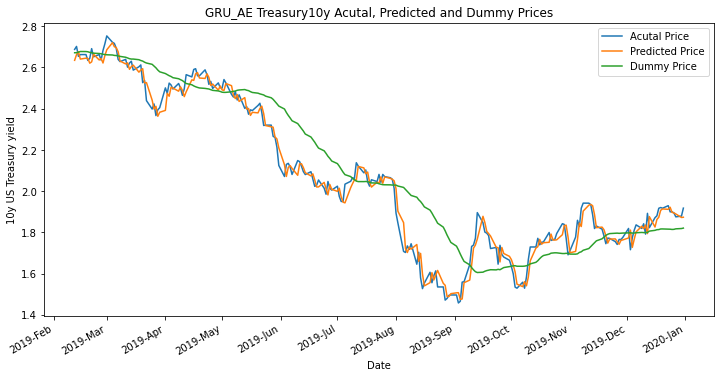

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

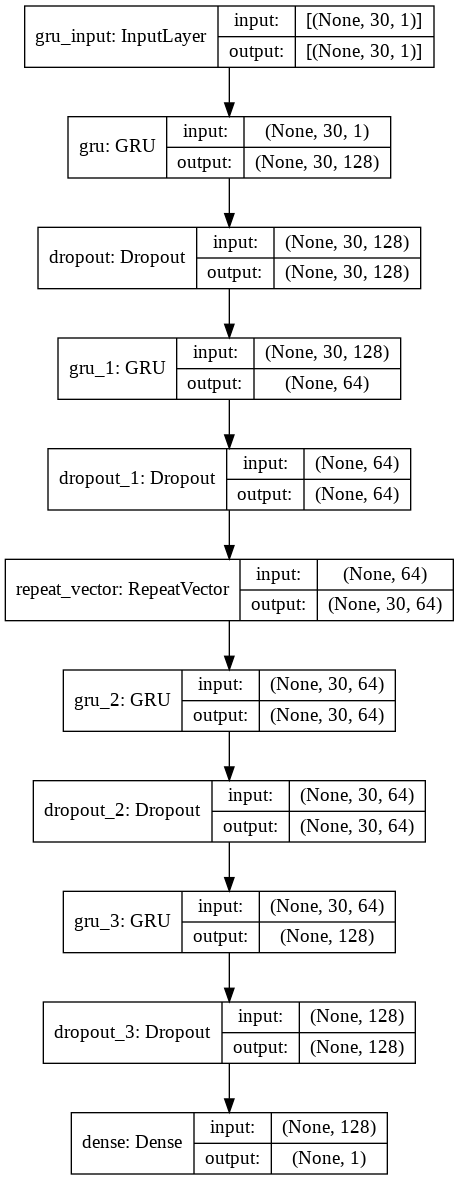

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0013573068658089059
RMSE:  0.03684164580754918
MAE:  0.029298985868122043
Dummy MSE:  0.011907945328582062
Dummy RMSE:  0.10912353242349727
Dummy MAE:  0.08287353397503001


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Treasury10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Treasury10y/assets
